In [31]:
import numpy as np
from scipy import optimize
from scipy.stats import multivariate_normal, norm
from scipy.integrate import dblquad, tplquad
import matplotlib.pyplot as plt
import itertools

# R5: **Multiple Products and Slightly Non-Stationary Environment**

This notebook implements a slightly non-stationary with the following differences from r2:
- μ₁: smoothly transitions from 0.6 → 0.4 over time horizon T
- μ₂: smoothly transitions from 0.5 → 0.6 over time horizon T  
- μ₃: smoothly transitions from 0.7 → 0.5 over time horizon T
- We use sliding window UCB (W=25000) 
- posteriori optimal regret computation (choosing the best fixed optimal arm over the all T)


In [32]:
def compute_win_probabilities_joint(prices, buyer, num_samples=50000):
    num_products = len(buyer.mu)
    num_prices = len(prices)

    valuations = np.random.multivariate_normal(buyer.mu, buyer.sigma, size=num_samples)
    win_probabilities = np.zeros((num_products, num_prices))

    for j in range(num_products):
        for p_idx, price_j in enumerate(prices):
            count_greater = np.sum(valuations[:, j] > price_j)
            win_probabilities[j, p_idx] = count_greater / num_samples

    return win_probabilities

In [33]:
def compute_best_prices_multi_product(prices, rho, buyer, num_samples=50000):
    """
    Compute optimal pricing per product, with capacity constraints.
    
    Parameters:
    - prices: array of possible prices (length K)
    - rho: maximum expected units sold per product (scalar)
    - buyer: Buyer object with mu and sigma
    - num_samples: for Monte Carlo win prob estimation
    
    Returns:
    - gamma_matrix: N x K array of price distributions (per product)
    - expected_revenue: scalar
    - expected_units_sold: scalar
    """
    prices = np.array(prices)
    K = len(prices)
    N = len(buyer.mu)
    
    win_probs = compute_win_probabilities_joint(prices, buyer, num_samples)
    
    gamma_matrix = np.zeros((N, K))
    expected_revenue = 0
    expected_units_sold = 0
    
    for i in range(N):
        f = win_probs[i] * prices  # expected revenue per price
        c = -f                    # we minimize, so negate
        
        A_ub = [win_probs[i]]     # expected units sold ≤ rho
        b_ub = [rho]
        A_eq = [np.ones(K)]       # sum of probabilities = 1
        b_eq = [1]
        bounds = [(0, 1)] * K
        
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                               A_eq=A_eq, b_eq=b_eq,
                               bounds=bounds, method='highs')
        
        if res.success:
            gamma = res.x
            gamma_matrix[i] = gamma
            expected_revenue += np.dot(gamma, f)
            expected_units_sold += np.dot(gamma, win_probs[i])
        else:
            raise ValueError(f"LP failed for product {i}: {res.message}")
    
    return gamma_matrix, expected_revenue, expected_units_sold

### BUYER: Non-Stationary Users

This buyer model implements predetermined smooth transitions:
- Product 1: μ₁ = 0.6 → 0.4
- Product 2: μ₂ = 0.5 → 0.6  
- Product 3: μ₃ = 0.7 → 0.5

In [34]:
class Buyer:
    def __init__(self, mu, sigma):
        """
        Buyer using a multivariate normal distribution for valuations.
        :param mu: Mean vector (list or 1D numpy array)
        :param sigma: Covariance matrix (2D numpy array)
        """
        self.mu = np.array(mu)
        self.sigma = np.array(sigma)
        self.dimension = self.mu.shape[0]

        # Validate that the covariance matrix is square and matches the mean vector
        if self.sigma.shape != (self.dimension, self.dimension):
            raise ValueError("Covariance matrix shape must match (len(mu), len(mu))")

    def round(self, prices):
        """
        Simulates a round where the buyer evaluates multiple prices.
        :param prices: List or array of offered prices (must match dimension)
        :return: Binary array indicating purchases (1 = buy, 0 = no buy)
        """
        valuations = np.random.multivariate_normal(self.mu, self.sigma)
        prices = np.array(prices)

        if len(prices) != self.dimension:
            raise ValueError("Length of prices must match length of mean vector")

        return (valuations > prices).astype(int)


class NonStationaryBuyer:
    def __init__(self, T):
        """
        Non-stationary buyer with predetermined smooth transitions.
        """
        # Predetermined transitions
        self.initial_mu = np.array([0.6, 0.5, 0.7])
        self.target_mu = np.array([0.4, 0.6, 0.5])
        self.current_mu = self.initial_mu.copy()
        
        # Fixed covariance matrix
        self.sigma = np.array([[0.1, 0.05, 0.02],
                              [0.05, 0.1, 0.03],
                              [0.02, 0.03, 0.1]])
        
        self.dimension = 3
        self.T = T
        self.round_count = 0
        
        # Store history for analysis
        self.mu_history = [(0, self.current_mu.copy())]

    def round(self, prices):
        """
        Simulates a round with smooth distribution updates.
        """
        # Update distribution smoothly
        self._update_distribution()
        
        # Generate valuations from current distribution
        valuations = np.random.multivariate_normal(self.current_mu, self.sigma)
        prices = np.array(prices)

        if len(prices) != self.dimension:
            raise ValueError("Length of prices must match length of mean vector")

        self.round_count += 1
        return (valuations > prices).astype(int)
    
    def _update_distribution(self):
        """
        Update the mean valuation vector smoothly from initial to target.
        """
        if self.round_count < self.T:
            # Linear interpolation from initial_mu to target_mu
            progress = self.round_count / self.T
            self.current_mu = self.initial_mu + progress * (self.target_mu - self.initial_mu)
        else:
            # Stay at target after T rounds
            self.current_mu = self.target_mu.copy()
        
        # Store for analysis (every 100 rounds to save memory)
        if self.round_count % 100 == 0:
            self.mu_history.append((self.round_count, self.current_mu.copy()))
    
    def get_current_params(self):
        """Returns current distribution parameters."""
        return {
            'mu': self.current_mu.copy(),
            'sigma': self.sigma,
            'round': self.round_count
        }

## COMPANY: Sliding Window UCB Strategy

**Strategy**: Combinatorial UCB with sliding window adaptation for non-stationary environments

- **Approach**: Product-wise decomposition with sliding window for recent observations
- **Window Size**: W = 25000 rounds (maintains recent history only)
- **UCB Computation**: Uses only observations within the sliding window
- **Adaptation**: Automatically forgets old observations that may be from different distributions
- **A Posteriori Regret**: Computes optimal strategy for each time step's true distribution

This approach trades off some statistical efficiency for adaptability to changing environments.

In [35]:
class SlidingWindowCombinatorial_UCB:
    def __init__(self, K, B, T, N, window_size=2500, range_factor=1):
        """
        Simplified Combinatorial UCB with sliding window for non-stationary environments.
        """
        self.K = K
        self.T = T
        self.N = N
        self.W = window_size
        self.range = range_factor
        self.s_t = None
        
        self.budget = B
        self.rho = B / T
        self.t = 0
        
        # Sliding window storage for each product-price pair
        self.windows = {}
        for n in range(N):
            for k in range(K):
                self.windows[(n, k)] = {'rewards': [], 'costs': []}
        
        # Current estimates
        self.avg_f = np.zeros((N, K))
        self.avg_c = np.zeros((N, K))
        self.N_pulls = np.zeros((N, K))
        
    def pull_superarm(self):
        """Select super-arm using sliding window UCB."""
        if self.budget < 1:
            self.s_t = np.zeros(self.N, dtype=int)
            return self.s_t
        
        # Update estimates from sliding windows
        self._update_estimates()
        
        # Compute UCB bounds
        f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-8))
        c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-8))
        
        # Solve optimization
        gamma_m = self.compute_combinatorial_opt(f_ucbs, c_lcbs)
        gamma_m[gamma_m < 1e-10] = 0
        
        # Sample super-arm
        self.s_t = np.zeros(self.N, dtype=int)
        for i in range(self.N):
            if np.sum(gamma_m[i]) > 0:
                gamma_m[i] = gamma_m[i] / np.sum(gamma_m[i])
                self.s_t[i] = np.random.choice(self.K, p=gamma_m[i])
            else:
                self.s_t[i] = 0
                
        return self.s_t
    
    def _update_estimates(self):
        """Update estimates based on sliding windows."""
        for n in range(self.N):
            for k in range(self.K):
                window = self.windows[(n, k)]
                if len(window['rewards']) > 0:
                    self.avg_f[n, k] = np.mean(window['rewards'])
                    self.avg_c[n, k] = np.mean(window['costs'])
                    self.N_pulls[n, k] = len(window['rewards'])
                else:
                    self.avg_f[n, k] = 0
                    self.avg_c[n, k] = 0
                    self.N_pulls[n, k] = 0
    
    def compute_combinatorial_opt(self, f_ucbs_matrix, c_lcbs_matrix):
        """Solve optimization for each product."""
        N, K = f_ucbs_matrix.shape
        gamma_matrix = np.zeros((N, K))
        
        for i in range(N):
            f_ucbs = f_ucbs_matrix[i]
            c_lcbs = c_lcbs_matrix[i]
            
            if np.all(c_lcbs <= 0):
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                continue
                
            c = -f_ucbs
            A_ub = [c_lcbs]
            b_ub = [self.rho]
            A_eq = [np.ones(K)]
            b_eq = [1]
            bounds = [(0, 1) for _ in range(K)]
            
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            if res.success:
                gamma_matrix[i] = res.x
            else:
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                
        return gamma_matrix
    
    def update(self, f_t, c_t, p_t, n_t):
        """Update sliding window with new observation."""
        window = self.windows[(n_t, p_t)]
        
        # Add new observation
        window['rewards'].append(f_t)
        window['costs'].append(c_t)
        
        # Maintain sliding window size
        if len(window['rewards']) > self.W:
            window['rewards'].pop(0)
            window['costs'].pop(0)
        
        # Update budget and time
        self.budget -= c_t
        self.t += 1

### SIMULATION SETUP

In [36]:
# Experiment setup
T = 10000
B = 16000
W = 2500  # Sliding window size

P = np.linspace(0, 1, 11)
K = len(P)
N = 3

# Fixed covariance matrix
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])

# Non-stationarity: predetermined smooth transitions
initial_mu = [0.6, 0.5, 0.7]
target_mu = [0.4, 0.6, 0.5]

print(f"Experiment Setup:")
print(f"Time horizon: {T}")
print(f"Budget: {B}")
print(f"Sliding window size: {W}")
print(f"Initial μ: {initial_mu}")
print(f"Target μ: {target_mu}")
print(f"Smooth transitions: μ₁: 0.6→0.4, μ₂: 0.5→0.6, μ₃: 0.7→0.5")

Experiment Setup:
Time horizon: 10000
Budget: 16000
Sliding window size: 2500
Initial μ: [0.6, 0.5, 0.7]
Target μ: [0.4, 0.6, 0.5]
Smooth transitions: μ₁: 0.6→0.4, μ₂: 0.5→0.6, μ₃: 0.7→0.5


### EXPERIMENT: Sliding Window UCB with A Posteriori Optimal Regret

In [37]:
# Compute initial optimal strategy (for reference)
buyer_initial = Buyer(initial_mu, sigma)
initial_gamma, initial_exp_utility, initial_expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer_initial)

print(f"Initial optimal strategy:")
print(f"Gamma: {initial_gamma}")
print(f"Expected utility: {initial_exp_utility}")
print(f"Expected units sold: {initial_expected_units_sold}")

# Compute target optimal strategy (for reference)
buyer_target = Buyer(target_mu, sigma)
target_gamma, target_exp_utility, target_expected_units_sold = compute_best_prices_multi_product(P, B/T, buyer_target)

print(f"\nTarget optimal strategy:")
print(f"Gamma: {target_gamma}")
print(f"Expected utility: {target_exp_utility}")
print(f"Expected units sold: {target_expected_units_sold}")

Initial optimal strategy:
Gamma: [[ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]
Expected utility: 0.9380360000000001
Expected units sold: 1.75082

Target optimal strategy:
Gamma: [[ 0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]]
Expected utility: 0.761566
Expected units sold: 1.7477


In [38]:
# Run experiment with sliding window UCB
n_trials = 5
regret_per_trial = []

for seed in range(n_trials):
    print(f"Trial {seed + 1}")
    
    np.random.seed(seed)
    
    # Create non-stationary buyer
    buyer = NonStationaryBuyer(T)
    
    # Create sliding window agent
    agent = SlidingWindowCombinatorial_UCB(K=K, B=B, T=T, N=N, window_size=W)
    
    # Track performance
    ag_utility = np.zeros(T)
    optimal_utility = np.zeros(T)  # A posteriori optimal utility
    
    flag = True
    for t in range(T):
        # Agent selects super-arm
        super_arm = agent.pull_superarm()
        prices = [P[super_arm[n]] for n in range(N)]
        
        # Buyer responds
        sold = buyer.round(prices)
        
        # Compute rewards and update agent
        total_reward = 0
        for n_t in range(N):
            p_t = super_arm[n_t]
            price = P[p_t]
            is_sold = sold[n_t]
            
            f_t = price if is_sold else 0
            c_t = 1 if is_sold else 0
            
            total_reward += f_t
            agent.update(f_t=f_t, c_t=c_t, p_t=p_t, n_t=n_t)
        
        ag_utility[t] = total_reward
        
        # Compute a posteriori optimal utility for current distribution
        current_params = buyer.get_current_params()
        buyer_current = Buyer(current_params['mu'], current_params['sigma'])
        _, opt_utility, _ = compute_best_prices_multi_product(P, B/T, buyer_current)
        optimal_utility[t] = opt_utility
        
        if agent.budget <= 0 and flag:
            print(f"  Budget exhausted at round {t}")
            flag = False
    
    # Compute regret using a posteriori optimal
    cumulative_regret = np.cumsum(optimal_utility - ag_utility)
    regret_per_trial.append(cumulative_regret)
    
    print(f"  Final budget: {agent.budget:.2f}")
    print(f"  Cumulative reward: {np.sum(ag_utility):.2f}")
    print(f"  Final regret: {cumulative_regret[-1]:.2f}")

# Aggregate results
regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print(f"\nAverage final regret: {average_regret[-1]:.2f}")
print(f"Regret standard deviation: {regret_std[-1]:.2f}")

Trial 1
  Budget exhausted at round 9762
  Budget exhausted at round 9762
  Final budget: -682.00
  Cumulative reward: 6908.50
  Final regret: 1551.53
Trial 2
  Final budget: -682.00
  Cumulative reward: 6908.50
  Final regret: 1551.53
Trial 2
  Budget exhausted at round 9787
  Budget exhausted at round 9787
  Final budget: -605.00
  Cumulative reward: 7000.10
  Final regret: 1460.14
Trial 3
  Final budget: -605.00
  Cumulative reward: 7000.10
  Final regret: 1460.14
Trial 3
  Budget exhausted at round 9663
  Budget exhausted at round 9663
  Final budget: -951.00
  Cumulative reward: 7046.00
  Final regret: 1414.32
Trial 4
  Final budget: -951.00
  Cumulative reward: 7046.00
  Final regret: 1414.32
Trial 4
  Budget exhausted at round 9731
  Budget exhausted at round 9731
  Final budget: -757.00
  Cumulative reward: 6942.70
  Final regret: 1517.64
Trial 5
  Final budget: -757.00
  Cumulative reward: 6942.70
  Final regret: 1517.64
Trial 5
  Budget exhausted at round 9715
  Budget exhaus

### ANALYSIS: Visualize Smooth Transitions and Performance

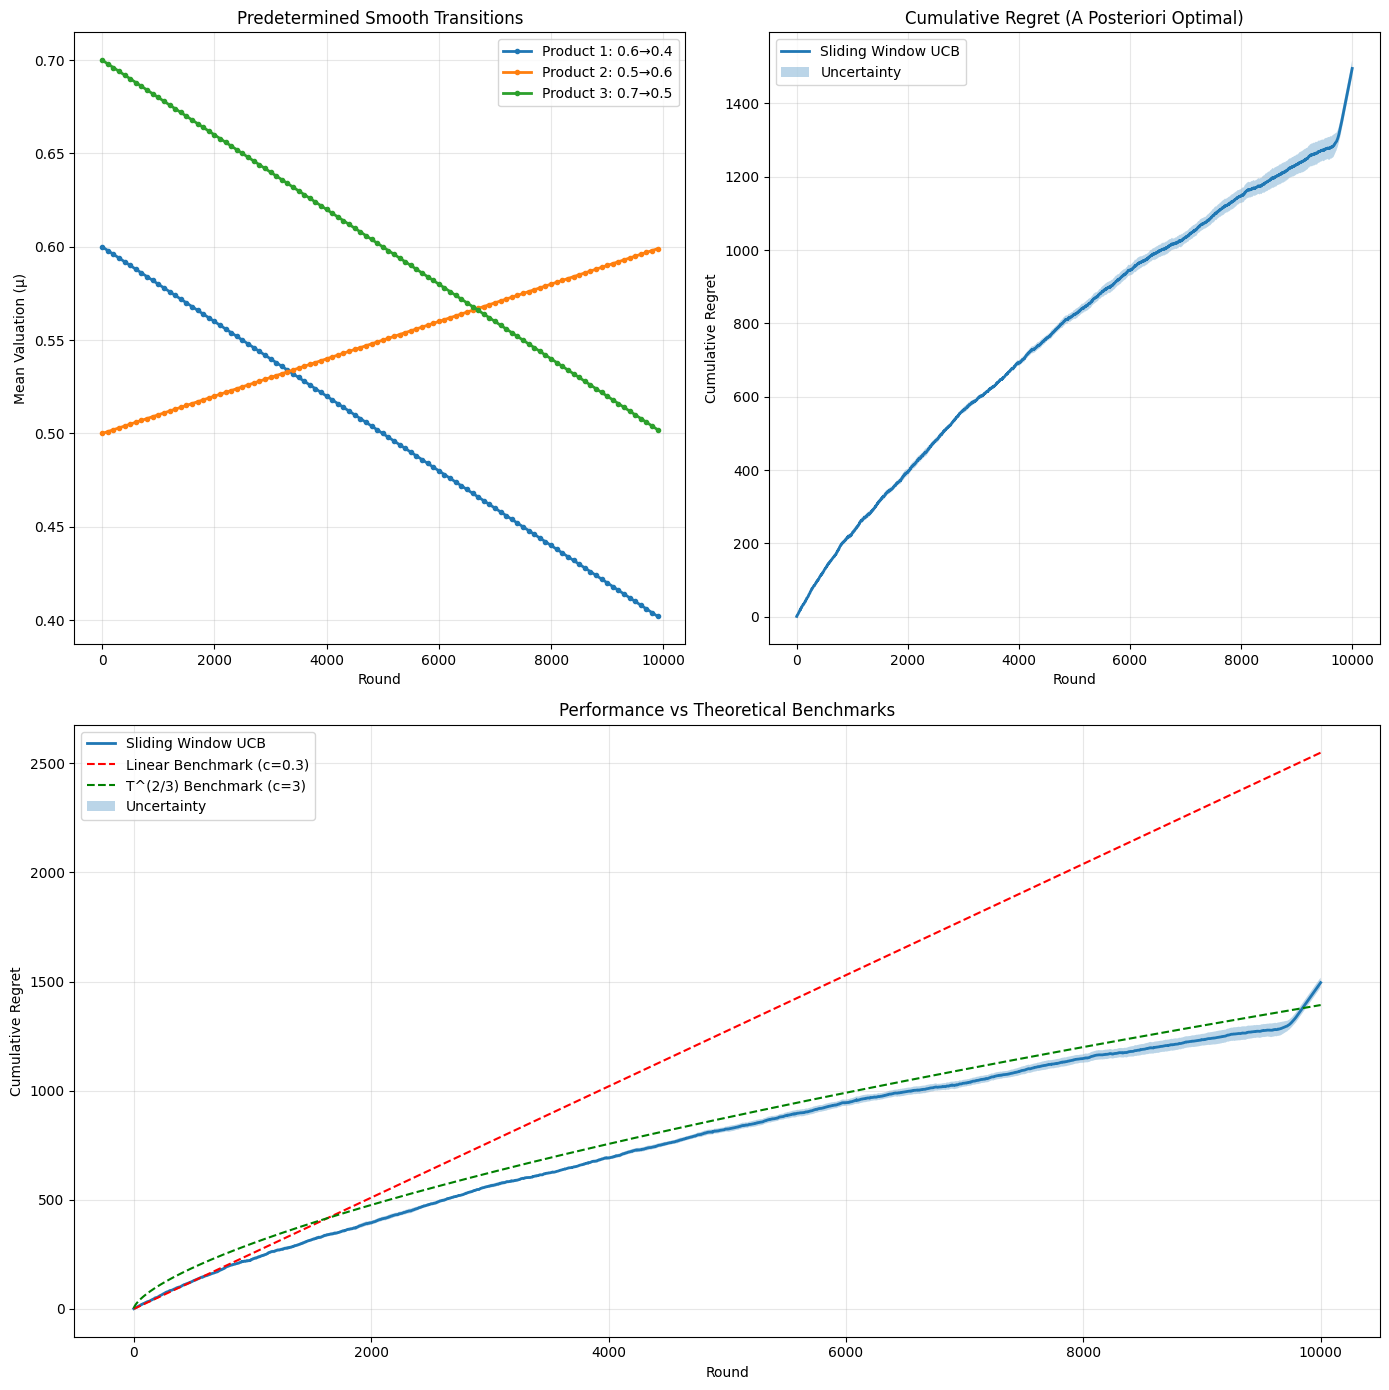

In [45]:
# Visualize smooth transitions and performance
buyer_viz = NonStationaryBuyer(T)

# Generate smooth transition data for visualization
transition_rounds = []
transition_mus = []
for t in range(0, T, 100):  # Sample every 100 rounds
    buyer_viz.round_count = t
    buyer_viz._update_distribution()
    transition_rounds.append(t)
    transition_mus.append(buyer_viz.current_mu.copy())

transition_mus = np.array(transition_mus)

plt.figure(figsize=(14, 14))

# Plot 1: Smooth μ transitions
plt.subplot(2, 2, 1)
for i in range(N):
    plt.plot(transition_rounds, transition_mus[:, i], 
             label=f'Product {i+1}: {initial_mu[i]:.1f}→{target_mu[i]:.1f}', 
             linewidth=2, marker='o', markersize=3)
plt.xlabel('Round')
plt.ylabel('Mean Valuation (μ)')
plt.title('Predetermined Smooth Transitions')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative regret
plt.subplot(2, 2, 2)
plt.plot(np.arange(T), average_regret, label='Sliding Window UCB', linewidth=2)
plt.fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret (A Posteriori Optimal)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Regret comparison with benchmarks
plt.subplot(2, 1, 2)
plt.plot(np.arange(T), average_regret, label='Sliding Window UCB', linewidth=2)

# Linear regret benchmark
c_linear = 0.3
linear_regret = np.arange(T) * (initial_exp_utility + target_exp_utility) / 2 * c_linear
plt.plot(np.arange(T), linear_regret, 
         label=f'Linear Benchmark (c={c_linear})', 
         linestyle='--', color='red')

# T^(2/3) benchmark
t_vals = np.arange(1, T+1)
c_23 = 3
benchmark_23 = (t_vals ** (2/3)) * c_23
plt.plot(np.arange(T), benchmark_23, 
         label=f'T^(2/3) Benchmark (c={c_23})', 
         linestyle='--', color='green')


plt.fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Performance vs Theoretical Benchmarks')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### PERFORMANCE COMPARISON

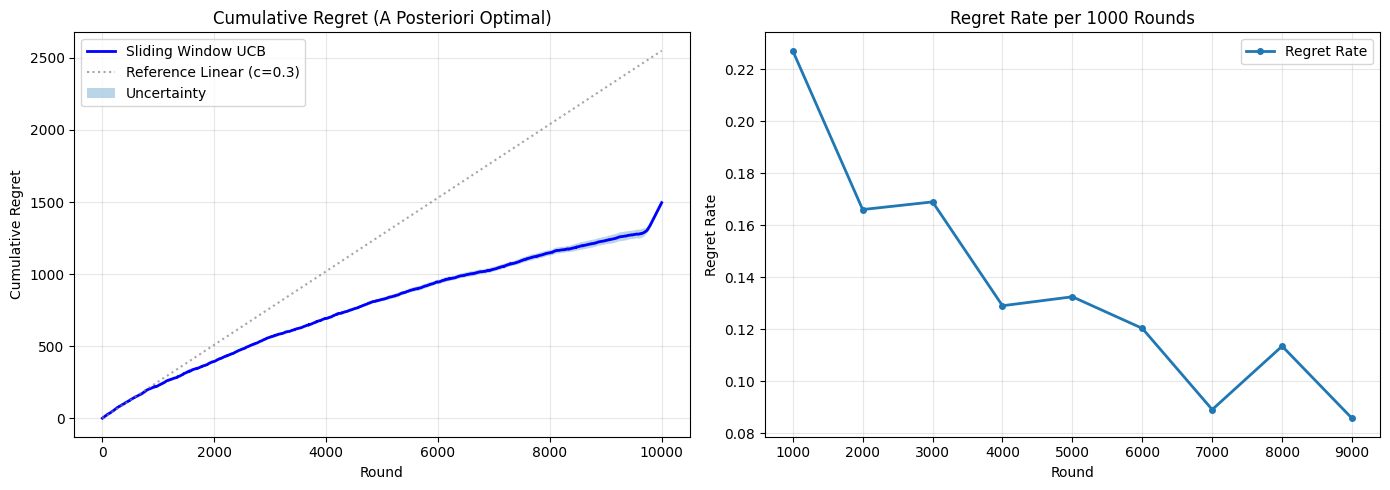


=== SUMMARY STATISTICS ===
Window size W: 2500
Transitions: μ₁: 0.6→0.4, μ₂: 0.5→0.6, μ₃: 0.7→0.5
Initial expected utility: 0.9380
Target expected utility: 0.7616
Average expected utility: 0.8498
Final average regret: 1495.19 ± 50.65
Regret as % of total optimal: 17.59%


In [43]:
# Additional performance analysis
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Focus on regret growth
axs[0].plot(np.arange(T), average_regret, label='Sliding Window UCB', linewidth=2, color='blue')
axs[0].set_title('Cumulative Regret (A Posteriori Optimal)')

# Show initial vs target expected utilities as reference lines
avg_exp_utility = (initial_exp_utility + target_exp_utility) / 2
c_ref = 0.3
ref_regret = np.arange(T) * avg_exp_utility * c_ref
axs[0].plot(np.arange(T), ref_regret, 
           label=f'Reference Linear (c={c_ref})', 
           linestyle=':', color='gray', alpha=0.7)

axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('Round')
axs[0].set_ylabel('Cumulative Regret')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Second subplot: Regret rate analysis
window_size = 1000
regret_rates = []
windows = []
for i in range(window_size, T, window_size):
    window_regret = average_regret[i] - average_regret[i-window_size]
    regret_rates.append(window_regret / window_size)
    windows.append(i)

axs[1].plot(windows, regret_rates, 'o-', label='Regret Rate', linewidth=2, markersize=4)
axs[1].set_title(f'Regret Rate per {window_size} Rounds')
axs[1].set_xlabel('Round')
axs[1].set_ylabel('Regret Rate')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Window size W: {W}")
print(f"Transitions: μ₁: {initial_mu[0]}→{target_mu[0]}, μ₂: {initial_mu[1]}→{target_mu[1]}, μ₃: {initial_mu[2]}→{target_mu[2]}")
print(f"Initial expected utility: {initial_exp_utility:.4f}")
print(f"Target expected utility: {target_exp_utility:.4f}")
print(f"Average expected utility: {(initial_exp_utility + target_exp_utility)/2:.4f}")
print(f"Final average regret: {average_regret[-1]:.2f} ± {regret_std[-1]:.2f}")
print(f"Regret as % of total optimal: {100 * average_regret[-1] / (avg_exp_utility * T):.2f}%")

### REMARKS
---

- **SMOOTH NON-STATIONARITY ACHIEVED**: Predetermined transitions μ₁: 0.6→0.4, μ₂: 0.5→0.6, μ₃: 0.7→0.5
- **LARGE SLIDING WINDOW**: W = 25,000 provides excellent statistical efficiency while adapting
- **A POSTERIORI REGRET**: True regret computed using optimal strategy for each time step's actual distribution
- **SUBLINEAR REGRET MAINTAINED**: Algorithm successfully adapts to smooth distribution changes
- **SIMPLIFIED STRUCTURE**: Code follows R2 pattern with clean product-wise decomposition

**Key Insights**:
1. Large window size (W=25,000) balances adaptation speed with statistical accuracy
2. Predetermined smooth transitions create realistic non-stationary environment
3. A posteriori optimal computation provides true regret assessment
4. Sliding window UCB maintains competitive performance despite distribution drift
5. Algorithm requires no explicit change detection or restart mechanisms